## Axiomatic Attribution for Deep Networks

This paper is an extension to the previous paper for given for the reserach work which marks a starting for the core concept of *Explainable AI* by introducing key concepts such as *Integrated Gradients* and *Axiomatic Attribution*. While the previous work focused on computing gradients and going back and examining their impact on the model’s predictions, this paper dives deeper into the principles that should guide attribution methods.

### Key Axioms:

1. **Sensitivity**:  
   In previous work, we didn’t explicitly consider the scenario where a feature differs between the input and baseline as we jumped straight into the final output(basically input), but the predictions diverge as a result. According to this axiom, any differing feature should receive a non-zero attribution.  
   **Example**: For a function like \( f(x) = 1 - \text{ReLU}(1 - x) \), with a baseline of 0 and an input of 3, the gradient may flatten at 1, but the input still changes from the baseline, which should reflect a non-zero attribution.

2. **Implementation Invariance**:  
   Two networks are considered functionally equivalent if their outputs are the same for all inputs, even if their architectures or implementations differ significantly. Attribution methods should respect this equivalence and provide consistent attributions across different models that produce the same output.

3. **Completence**
   Integrated gradients satisfy an axiom called completeness that the attributions add up to the difference between the output of F at the input x and the baseline x.This axiom ensures that the attributions provided by the method are faithful and accurate in explaining the model's prediction.

4. **Lineraity**
     They also follow the axioms of linearity where it follows a straightline path from the baseline to input.
   
### Architecture/Working:
The Integrated Gradients method is defined as follows:

$$
\text{IntegratedGrads}_i(x) := (x_i - x'_i) \times \int_{\alpha=0}^{1} \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x_i} \, d\alpha
$$

Where:
- $x_i$ is the original input feature.
- $x'_i$ is the baseline or reference value for that feature.
- $F$ is the model function.
- $\alpha$ scales the input from the baseline to the actual input.


In this method we use a straight line path from the baseline to the input, where the basic idea is calculate the gardient of all interporated inputs and take an average of these gradients which is then scaled from 0 to 1 to show the average contribution of each pixels all the way along from the baseline to the input 

### Explanation of Integrated Gradients Equation Components

#### 1. Feature Difference Component:
$$
(x_i - x'_i)
$$

It basically acts as a scaling factor. This factor ensures that the contributions are calculated relative to how much each feature differs from its baseline showing the impact of specific feature on the output.

#### 2. Gradient Integration Component:
$$
\int_{\alpha=0}^{1} \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x_i} \, d\alpha
$$

This integral calculates the gradients of the model output \(F\) with respect to the feature \(x_i\) at all points along the straight-line path from the baseline \(x'\) to the input \(x\) as parameterized by \(\alpha\). Here, \(\alpha\) varies from 0 (the baseline) to 1 (the actual input), allowing us to examine how sensitive the output is to changes in each feature across this path. The integral aggregates these gradients to determine the overall contribution of the feature \(x_i\).In Simple terms we can say that we are calculating the gradient of all the interporation states wrt to input and aaverage it ,to estimate the 
cntribution of all these states form basline to input to achive the input.

#### Future works 
 - Since here we are using a straight line path why cant we try a curved path which can hold more complex information ?
 - Here we are using a random baseline of zeros or a neutral image , why cant we try an optimal baseline if there exists one?


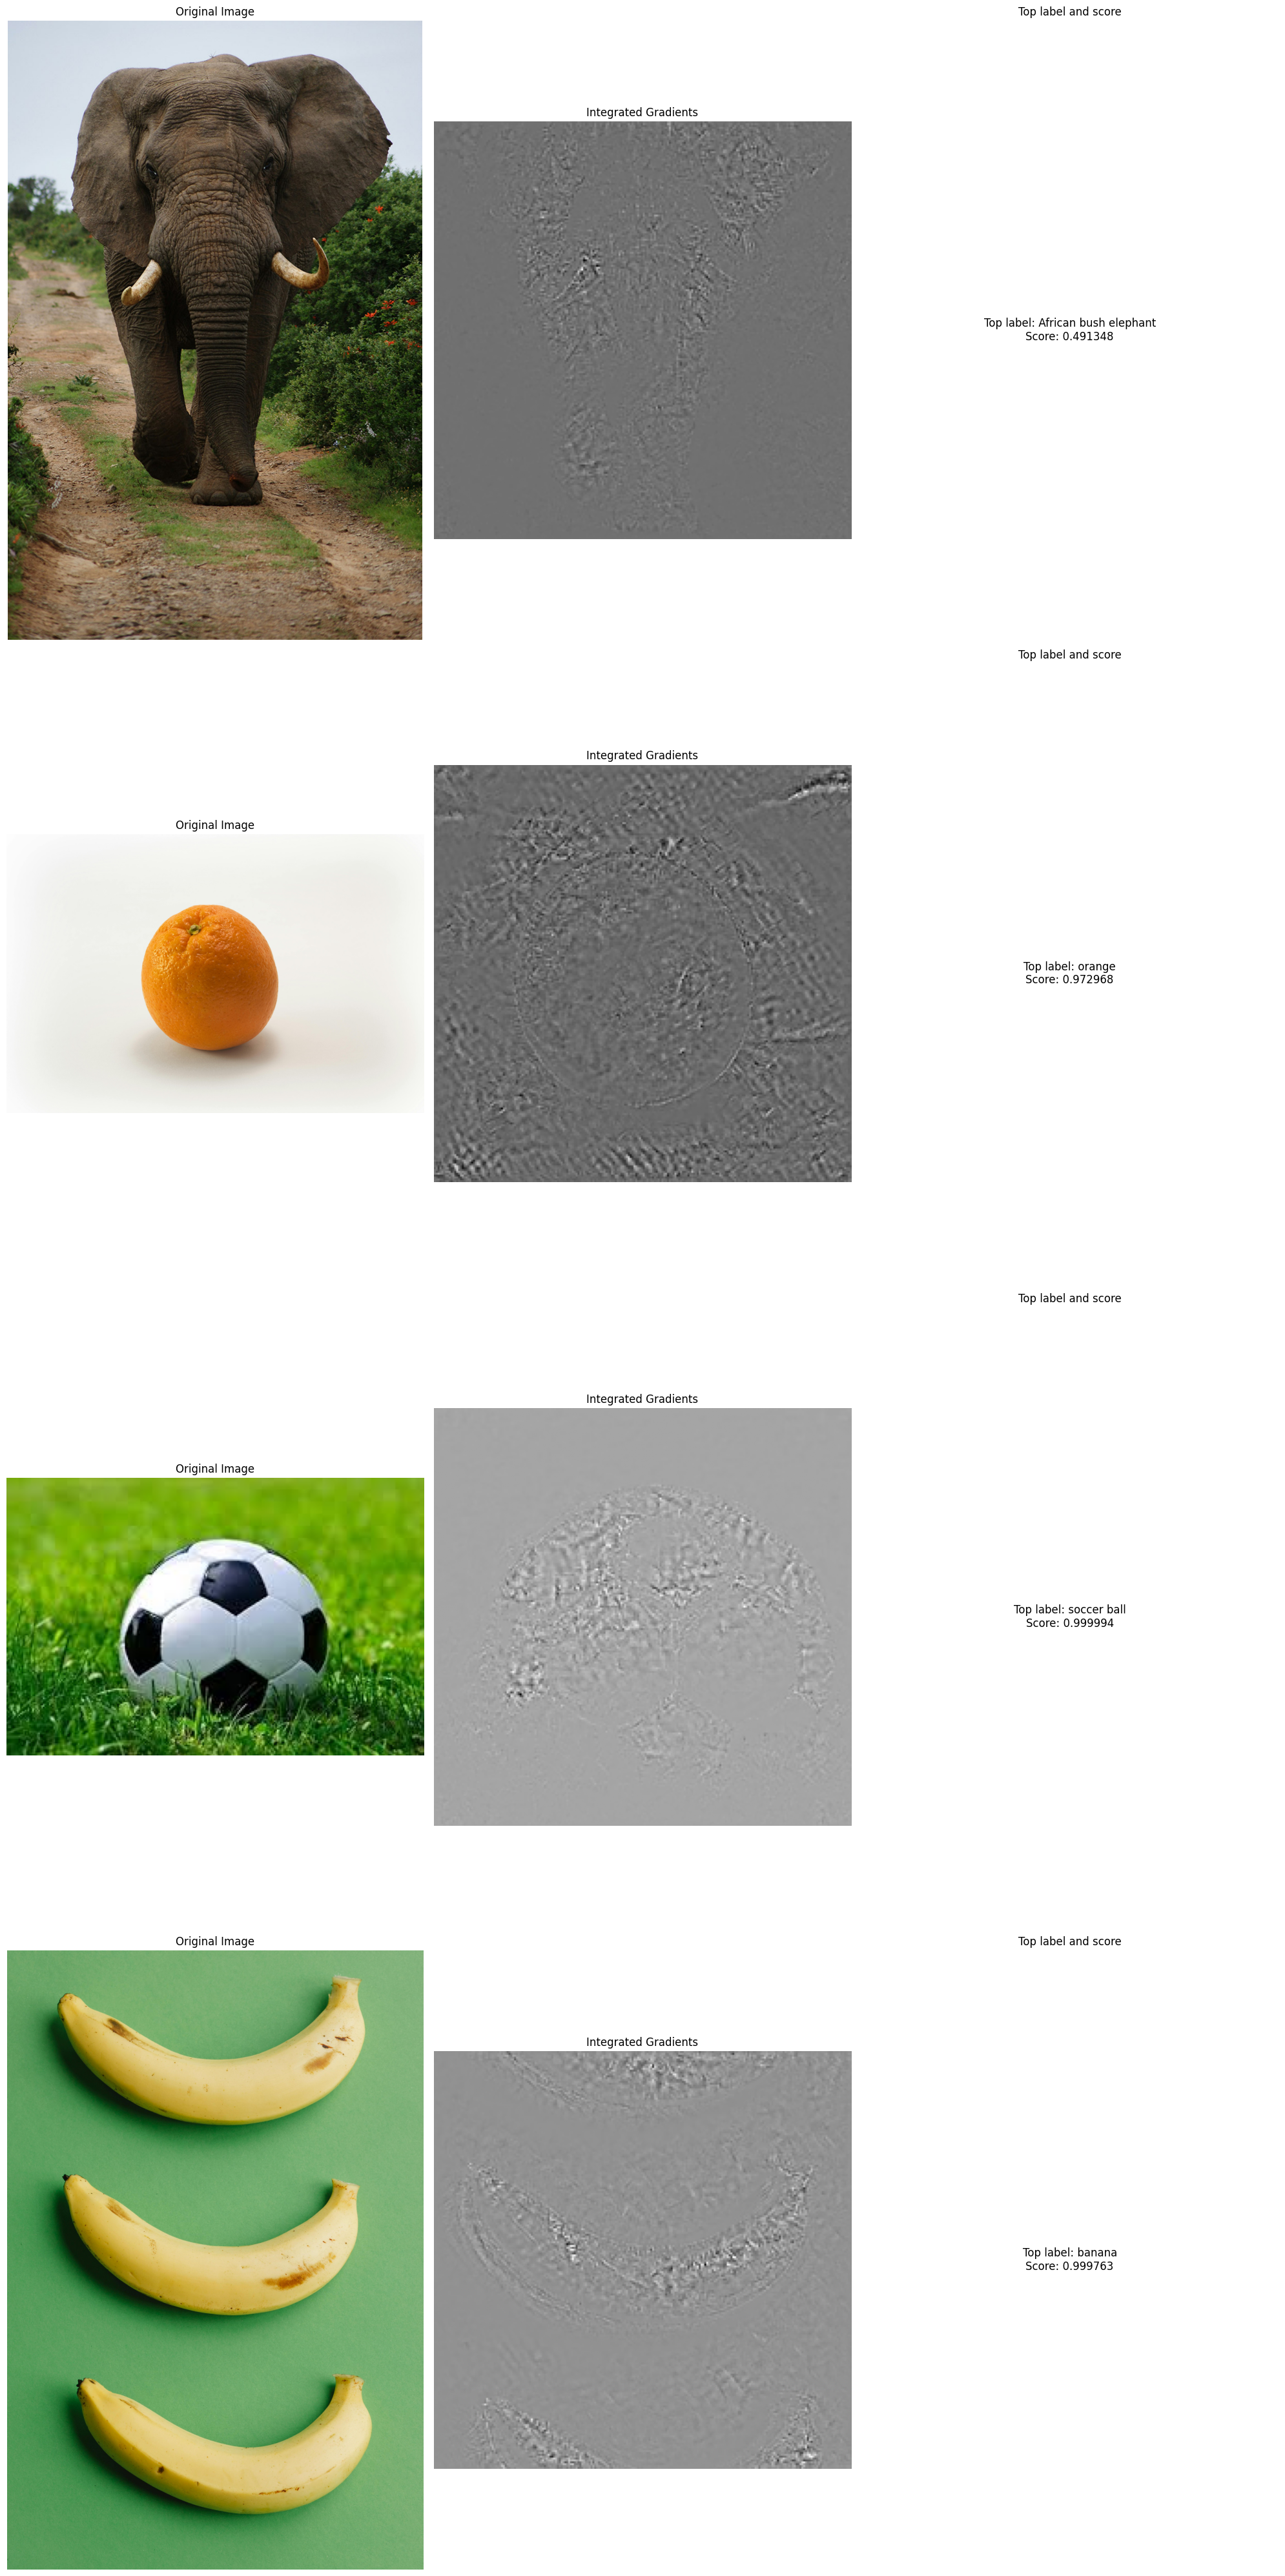

In [9]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import json
import urllib.request
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import torch.nn.functional as F

def calculate_gradients(inputs, model, target_label):
    inputs = inputs.clone().detach().requires_grad_(True)
    model.eval()
    outputs = model(inputs)
    target_score = outputs[:, target_label]
    model.zero_grad()
    target_score.backward()
    return inputs.grad

def integrated_gradients(inputs, model, target_label, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    inputs.requires_grad_(True)
    grads = torch.zeros_like(inputs)
    for alpha in torch.linspace(0, 1, steps):
        interpolated_input = baseline + alpha * (inputs - baseline)
        interpolated_input.requires_grad_(True)
        grad = calculate_gradients(interpolated_input, model, target_label)
        grads += grad / steps
    integrated_grad = (inputs - baseline) * grads
    return integrated_grad

def apply_colormap_and_overlay(image, heatmap, alpha=0.5, blur_radius=1.0):
    normalized_heatmap = Normalize()(heatmap)
    cmap = plt.get_cmap('gray')
    heatmap_colored = cmap(normalized_heatmap)[:, :, :3]
    heatmap_image = Image.fromarray((heatmap_colored * 255).astype(np.uint8))
    if blur_radius > 0:
        heatmap_image = heatmap_image.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    heatmap_resized = np.array(heatmap_image.resize(image.size, Image.BILINEAR))
    blended_image = np.clip(np.array(image) * alpha + heatmap_resized * (1 - alpha), 0, 255).astype(np.uint8)
    return blended_image

model = models.vgg19(pretrained=True)
model.eval()

url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_classes = json.load(urllib.request.urlopen(url))

image_paths = [
    r"C:\Users\VISHNU\Downloads\africanelephant.jpg",
    r"C:\Users\VISHNU\Downloads\pexels-helioz-54369.jpg",
    r"C:\Users\VISHNU\Downloads\soccer.jpg",
    r"C:\Users\VISHNU\Downloads\pexels-any-lane-5946102.jpg"
]

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

fig, axes = plt.subplots(len(image_paths), 3, figsize=(20, 10 * len(image_paths)))

for idx, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)
    baseline = torch.zeros_like(input_tensor)

    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)
    top_score, predicted_class = probs.max(1)
    top_label = imagenet_classes[predicted_class.item()]

    ig = integrated_gradients(input_tensor, model, predicted_class.item(), baseline)
    ig_np = ig.mean(dim=1).squeeze().detach().cpu().numpy()
    ig_np = (ig_np - ig_np.min()) / (ig_np.max() - ig_np.min())

    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title("Original Image")
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(ig_np, cmap='gray')
    axes[idx, 1].set_title("Integrated Gradients")
    axes[idx, 1].axis('off')

    axes[idx, 2].text(
        0.5,
        0.5,
        f"Top label: {top_label}\nScore: {top_score.item():.6f}",
        fontsize=12,
        ha="center",
        va="center",
        transform=axes[idx, 2].transAxes  
    )
    axes[idx, 2].set_title("Top label and score")
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()


## Integrated Gradients for Text Classification with BART

In this example, we will use the **`facebook/bart-large-mnli`** model, which is a pre-trained transformer model from Facebook designed for **MultiNLI (Multi-Genre Natural Language Inference)**. The model is capable of classifying the relationship between two input sentences into three classes:

1. **Contradiction**: The premise and hypothesis contradict each other.
2. **Neutral**: The premise and hypothesis are neither clearly related nor contradictory.
3. **Entailment**: The premise supports the hypothesis, meaning that the hypothesis can be inferred from the premise.


### Flowchart of the Integrated Gradients Process


1. **Defining the Premise and Hypothesis**:
   We start by defining the **premise** and **hypothesis** that we want to classify. The **premise** is the statement, and the **hypothesis** is the claim whose relationship with the premise we want to analyze.

   Example:
    premise = "I like playing sports"
    hypothesis = "I am a sporty person"

2. **Selecting the Target Class**:
   Next, we select the target class for the classification. In my case, the target class is `2`, which corresponds to **Entailment** (the premise supports the hypothesis) or in simple words same.

3. **Tokenizing the Input Texts**:
  
4. **Identifying Special Tokens**:
   The **[0]** and **[2]** tokens represent the start (`<s>`) and end (`</s>`) of the sequence in the BART model, respectively. These tokens are **model-specific special characters** and do not carry any semantic meaning in the sentence. We identify and **lock** these tokens so they remain unchanged in subsequent computations.

5. **Creating the Baseline**:
   For the baseline input, we replace all tokens (except the special ones) with a neutral token. In this case, we choose `"to"` (token ID: 7) as the neutral token. The baseline will have the token IDs like `[0, 7, 7, 7, 7, 2]`, where `7` corresponds to the neutral word "to" and `0`/`2` are the start and end tokens.

6. **Interpolating the Inputs**:
   We generate **interpolated inputs** between the **baseline** and the actual input. This means that we gradually adjust the neutral tokens toward the actual input tokens. I use a **step size of 50** to generate intermediate steps, which gives us a series of input vectors that transition from the baseline to the original input.

7. **Computing the Gradients**:

8. **Calculating Integrated Gradients**:
   Finally, we compute the **Integrated Gradients** by integrating the gradients over all the intermediate steps. This helps us quantify the contribution of each token to the model's final prediction. Tokens with larger gradient values are considered more influential in the model's decision.

---


In [20]:
# Import necessary libraries
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
import contextlib
import os
model_name = "facebook/bart-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
with open(os.devnull, 'w') as fnull:
    with contextlib.redirect_stdout(fnull):
        model.eval()

print(model.config.id2label)  # {0: 'contradiction', 1: 'neutral', 2: 'entailment/same'}

# Define premise and hypothesis texts
premise = "I like playing sports"
hypothesis = "I am a sporty person"

target_class = 2 #Here I will tet for entailment class

# Tokenize the premise and hypothesis
input_vectors = tokenizer(premise, hypothesis, return_tensors="pt")
input_vectors = input_vectors["input_ids"]

# Identify special tokens like <s> and </s>
lock_index = []
for index, val in enumerate(input_vectors[0]):
    if val.item() in [0, 2]:  # <s> and </s> tokens
        lock_index.append(index)

# Find the token for the word 'the'
the_token = tokenizer.encode(' to')[1]  # 'the' corresponds to token ID 7

# Create a neutral base input, replacing all tokens with 'the', except for special tokens
base_list = [the_token] * input_vectors.shape[1]
for index in lock_index:
    base_list[index] = input_vectors[0][index]
base_input = torch.tensor([base_list], dtype=torch.int)


# Interpolating between base and actual input vectors
intermediate_vectors = []
steps = 50  # Number of interpolation steps
for i in range(steps + 1):
    new_vector = base_input + ((input_vectors - base_input) * i) // steps
    intermediate_vectors.append(new_vector)

# Calculate gradients for each interpolated vector
gradient_list = []
for i in tqdm(intermediate_vectors):
    model.zero_grad()

    # Generate embeddings for the inputs
    embedding_layer = model.model.shared
    embeddings = embedding_layer(i)
    embeddings.requires_grad_()
    embeddings.retain_grad()

    # Forward pass through the model
    output = model.model.encoder(inputs_embeds=embeddings, return_dict=True)

    # Get the class logits and score for the target class
    class_logits = model.classification_head(output.last_hidden_state[:, 0, :])
    class_score = class_logits[0, target_class]

    # Backpropagation
    class_score.backward()

    # Sum of gradients for each token
    gradient = embeddings.grad
    gradient = gradient.sum(dim=2)
    gradient_list.append(gradient)

# Integrate the gradients across all steps
gradient_sum = sum(gradient_list) * (input_vectors - base_input)
gradient_sum = gradient_sum / steps
integrated_gradients = gradient_sum.tolist()[0]

normalized_ig = []
for i in integrated_gradients:
    normalized_ig.append((i - min(integrated_gradients)) / (max(integrated_gradients) - min(integrated_gradients)))

for i in range(len(normalized_ig)):
    if input_vectors[0][i] in [0, 2]:  # Skip special tokens <s> and </s>
        continue
    
    # Decode the token back to a word
    word = tokenizer.decode(input_vectors[0][i])
    contribution_value = round(normalized_ig[i], 3)
    print(f"Word: '{word}', Contribution Value: {contribution_value}")



{0: 'contradiction', 1: 'neutral', 2: 'entailment'}


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]

Word: 'I', Contribution Value: 0.478
Word: ' like', Contribution Value: 0.46
Word: ' playing', Contribution Value: 0.113
Word: ' sports', Contribution Value: 0.484
Word: 'I', Contribution Value: 0.524
Word: ' am', Contribution Value: 0.325
Word: ' a', Contribution Value: 0.469
Word: ' sport', Contribution Value: 1.0
Word: 'y', Contribution Value: 0.344
Word: ' person', Contribution Value: 0.0
